# Initial data read
Notebook to begin exploring the UK air pollution data made available by the department for environment, food and rural affairs: [UK Air Information Resource](https://uk-air.defra.gov.uk/).  
&copy; Crown 2020 copyright Defra via uk-air.defra.gov.uk, licenced under the [Open Government Licence (OGL)](http://www.nationalarchives.gov.uk/doc/open-government-licence/version/2/).  
  
First, we will inspect air pollution readings from a measurement station in Oxford, UK.  
  
To find data for a new site, follow these steps:
- Open the [monitoring site search](https://uk-air.defra.gov.uk/networks/find-sites) at the UK Air Information Resource website.
- Select a monitoring network of interest: all data processing code and notebooks have used the 'Automatic Urban and Rural Monitoring Network' (AURN).
- Choose to search by postcode or region. Select 'Search Network' or 'Search Region' to see a list of results.
- Find a site of interest from the results table; select 'View site networks and parameters' from the 'Further information' column.
- Select the 'Networks' tab on the site information page; select 'Pre-Formatted Data Files'.
- This page will display the available years of air pollution data for the chosen site; the URL of this page will end with a 'site_id' code: this code should be used to define the 'location' variable in the notebook below. Similarly, the available years can be used to define the 'start_year' and 'end_year' variables.


Notebook successfully:
- Achieves initial read-in of air pollution data from Oxford St Ebbes measurement station
- Prints out summaries on data availability

In [1]:
%load_ext autoreload
%load_ext watermark
%load_ext lab_black

In [2]:
%autoreload 2

In [3]:
%watermark -ntz -p pandas -a Simon-Lee-UK

Simon-Lee-UK Sun Oct 04 2020 13:20:31 BST 

pandas 1.1.2


In [4]:
import sys
import time
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import altair as alt
import seaborn as sns
from tqdm import tqdm

repo_root = Path.cwd().resolve().parent

sys.path.append(str(repo_root))
interim_data_path = repo_root / "data" / "interim"

from src.inspect_site import preview_data, monitoring_site_summary

sleep_time = 1.5

## Data info
Location: Oxford St Ebbes (OX8)
All Data GMT hour ending  
Status: R = Ratified / P = Provisional / P* = As supplied  
Data available: 2008 - 2020
  
### Raw columns (2020):
`Date` - format: 'dd-mm-yyyy'  
`time` - 24 hour, e.g. '19:00'  
`PM<sub>10</sub> particulate matter (Hourly measured)` - $PM_{10}$ particulate matter with diameter $< 10 \;\mu m$  
`status` - ratified / provisional / as supplied  
`unit` - $\mu g \:/\: m^{3}$ (FIDAS)  
`Nitric oxide` - 'NO'  
`status.1` - ratified / provisional / as supplied  
`unit.1` - $\mu g \:/\: m^{3}$  
`Nitrogen dioxide` - 'NO$_2$'  
`status.2` - ratified / provisional / as supplied  
`unit.2` - $\mu g \:/\: m^{3}$  
`Nitrogen oxides as nitrogen dioxide` - 'NO$_x$ as NO$_2$'  
`status.3` - ratified / provisional / as supplied  
`unit.3` - $\mu g \:/\: m^{3}$  
`PM<sub>2.5</sub> particulate matter (Hourly measured)` - $PM_{2.5}$ particulate matter with diameter $< 2.5 \;\mu m$    
`status.4` - ratified / provisional / as supplied  
`unit.4` - $\mu g \:/\: m^{3}$ (Ref.eq)  
  
#### Additional columns found in data from previous years
`Volatile PM<sub>2.5</sub> (Hourly measured)` - sub-category of particulate matter measurement ($< 2.5 \;\mu m$)  
`Volatile PM2.5 (Hourly measured)` - alternate column title for the above change observed between 2010 and 2011; never both observed for same year's data; 'column_consistency' function renames this column to match the above  
`Volatile PM<sub>10</sub> (Hourly measured)` - sub-category of particulate matter measurement ($< 10 \;\mu m$)  
`Non-volatile PM<sub>2.5</sub> (Hourly measured)` - sub-category of particulate matter measurement ($< 2.5 \;\mu m$)  
`Non-volatile PM<sub>10</sub> (Hourly measured)` - sub-category of particulate matter measurement ($< 10 \;\mu m$)  
  
Volatile/Non-volatile measurements are only available in some years. The two values add to give the generic particulate matter measurement for each hour; this value is available for both sizes in all available years of data. For now, volatile/non-volatile values will be dropped because they cannot be compared across the full range of data.

## Data read functions
Below, define functions for reading and pre-processing the raw data. These functions will later be exported out to a separate package for ease of maintenance and for access from future notebooks.

In [5]:
def column_consistency(raw_data):
    column_consist_dict = {
        "Volatile PM2.5 (Hourly measured)": "Volatile PM<sub>2.5</sub> (Hourly measured)"
    }

    consistent_columns = raw_data.rename(columns=column_consist_dict)
    return consistent_columns


def column_conversion(raw_data):
    column_dict = {
        "Date": "date",
        "PM<sub>10</sub> particulate matter (Hourly measured)": "pm_10",
        "status": "status_pm_10",
        "unit": "unit_pm_10",
        "Nitric oxide": "nitric_oxide",
        "status.1": "status_nitric_oxide",
        "unit.1": "unit_nitric_oxide",
        "Nitrogen dioxide": "nitrogen_dioxide",
        "status.2": "status_nitrogen_dioxide",
        "unit.2": "unit_nitrogen_dioxide",
        "Nitrogen oxides as nitrogen dioxide": "NO2_eq",
        "status.3": "status_NO2_eq",
        "unit.3": "unit_NO2_eq",
        "PM<sub>2.5</sub> particulate matter (Hourly measured)": "pm_2_5",
        "status.4": "status_pm_2_5",
        "unit.4": "unit_pm_2_5",
    }

    converted_columns = raw_data.rename(columns=column_dict)
    converted_columns = extend_date_with_time(converted_columns)
    return converted_columns


def extend_date_with_time(raw_data):
    extended_date = raw_data.copy()
    extended_date.time = extended_date.time.replace("24:00", "00:00")

    extended_date = datetime_conversion(extended_date, date_format="%d-%m-%Y")
    update_mask = extended_date.time == "00:00"
    extended_date.loc[update_mask, "date"] = extended_date.loc[
        update_mask, "date"
    ] + pd.to_timedelta(1, unit="d")
    extended_date.date = extended_date.date.astype("str")

    extended_date.date = extended_date.date + " " + extended_date.time
    return extended_date


def datetime_conversion(raw_data, target_column="date", date_format="%Y-%m-%d %H:%M"):
    converted_datetime = raw_data.copy()
    try:
        converted_datetime[target_column] = pd.to_datetime(
            converted_datetime[target_column], format=date_format
        )
    except ValueError:
        print(
            "date_format in 'datetime_conversion' function could not be applied generally"
        )
        converted_datetime[target_column] = pd.to_datetime(
            converted_datetime[target_column]
        )

    return converted_datetime

## Combining multiple years of data
Data is available for years 2008 - 2020 with access URLs such as: 'https://uk-air.defra.gov.uk/data_files/site_data/OX8_2008.csv' providing the data for each individual year.  

Use this consistent csv file name format to loop through the available years and save a composite csv file containing all available data.  
Start by defining the list of years we want to download data for:

In [6]:
location = "OX8"
start_year = 2007
end_year = 2020

preview_df, valid_data_years = preview_data(location, start_year, end_year)

Generating data preview:  93%|█████████▎| 13/14 [00:15<00:01,  1.13s/it]

-------
WARNING
-------
Could not read data from: https://uk-air.defra.gov.uk/data_files/site_data/OX8_2007.csv
Check the URL to ensure location code, year and file extension are all valid!


Generating data preview: 100%|██████████| 14/14 [00:15<00:00,  1.14s/it]

Preview data sampled from 2020


In [7]:
preview_df

,Date,time,PM<sub>10</sub> particulate matter (Hourly measured),status,unit,Nitric oxide,status.1,unit.1,Nitrogen dioxide,status.2,unit.2,Nitrogen oxides as nitrogen dioxide,status.3,unit.3,PM<sub>2.5</sub> particulate matter (Hourly measured),status.4,unit.4
0,01-01-2020,01:00,37.950,R,ugm-3 (FIDAS),0.91869,R,ugm-3,24.21934,R,ugm-3,25.62798,R,ugm-3,31.958,R,ugm-3 (Ref.eq)
1,01-01-2020,02:00,38.125,R,ugm-3 (FIDAS),0.51926,R,ugm-3,24.40668,R,ugm-3,25.20287,R,ugm-3,32.783,R,ugm-3 (Ref.eq)
2,01-01-2020,03:00,40.425,R,ugm-3 (FIDAS),0.23966,R,ugm-3,21.54081,R,ugm-3,21.90828,R,ugm-3,35.661,R,ugm-3 (Ref.eq)
3,01-01-2020,04:00,40.075,R,ugm-3 (FIDAS),0.68902,R,ugm-3,22.30931,R,ugm-3,23.36579,R,ugm-3,35.472,R,ugm-3 (Ref.eq)
4,01-01-2020,05:00,39.800,R,ugm-3 (FIDAS),0.62910,R,ugm-3,23.17549,R,ugm-3,24.14010,R,ugm-3,35.354,R,ugm-3 (Ref.eq)
5,01-01-2020,06:00,38.100,R,ugm-3 (FIDAS),0.26962,R,ugm-3,21.44932,R,ugm-3,21.86273,R,ugm-3,34.411,R,ugm-3 (Ref.eq)
6,01-01-2020,07:00,38.600,R,ugm-3 (FIDAS),0.68902,R,ugm-3,22.67369,R,ugm-3,23.73017,R,ugm-3,34.340,R,ugm-3 (Ref.eq)
7,01-01-2020,08:00,39.300,R,ugm-3 (FIDAS),0.53923,R,ugm-3,22.72117,R,ugm-3,23.54798,R,ugm-3,35.189,R,ugm-3 (Ref.eq)


In [8]:
valid_data_years

[2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008]

In [9]:
status_str = "status"
unit_str = "unit"
status_offset = -1
unit_offset = -2

### Inconsistent column titles between data sets
Following initial read in of some test years of data, some column titles were seen for certain years of data but not others. The full set of observed columns (ignoring associated 'status' and 'unit' columns) was copied to the DataFrame defined in the cell below. This DataFrame is used later to record the presence/absence of each column for each available year of air pollution data. 

### Looping to read data for years of interest
We also fill the DataFrame defined in the cell above based on the presence/absence of each possible column for each individual year of data after it is read from the source URL.

Inspect which columns appear in which years' data sets:

In [10]:
data_dict, measurement_summary, status_summary, unit_summary = monitoring_site_summary(
    location,
    valid_data_years,
    status_str=status_str,
    unit_str=unit_str,
    status_offset=status_offset,
    unit_offset=unit_offset,
)

Generating summary tables: 100%|██████████| 13/13 [00:16<00:00,  1.24s/it]


In [11]:
measurement_summary

,Data (Year),Date,time,PM<sub>10</sub> particulate matter (Hourly measured),Nitric oxide,Nitrogen dioxide,Nitrogen oxides as nitrogen dioxide,PM<sub>2.5</sub> particulate matter (Hourly measured),Non-volatile PM<sub>10</sub> (Hourly measured),Non-volatile PM<sub>2.5</sub> (Hourly measured),Volatile PM<sub>10</sub> (Hourly measured),Volatile PM<sub>2.5</sub> (Hourly measured),Volatile PM2.5 (Hourly measured)
0,2020,True,True,True,True,True,True,True,False,False,False,False,False
1,2019,True,True,True,True,True,True,True,True,True,True,True,False
2,2018,True,True,True,True,True,True,True,True,True,True,True,False
3,2017,True,True,True,True,True,True,True,True,True,True,True,False
4,2016,True,True,True,True,True,True,True,True,True,True,True,False
5,2015,True,True,True,True,True,True,True,True,True,True,True,False
6,2014,True,True,True,True,True,True,True,True,True,True,True,False
7,2013,True,True,True,True,True,True,True,True,True,True,True,False
8,2012,True,True,True,True,True,True,True,True,True,True,True,False
9,2011,True,True,True,True,True,True,True,True,True,True,True,False


In [12]:
m_plot_df = measurement_summary.copy()
m_plot_df.set_index("Data (Year)", inplace=True)
m_plot_df.sort_index(inplace=True)
m_plot_df.columns.name = "Measurement Column"
m_plot_df = m_plot_df.transpose()

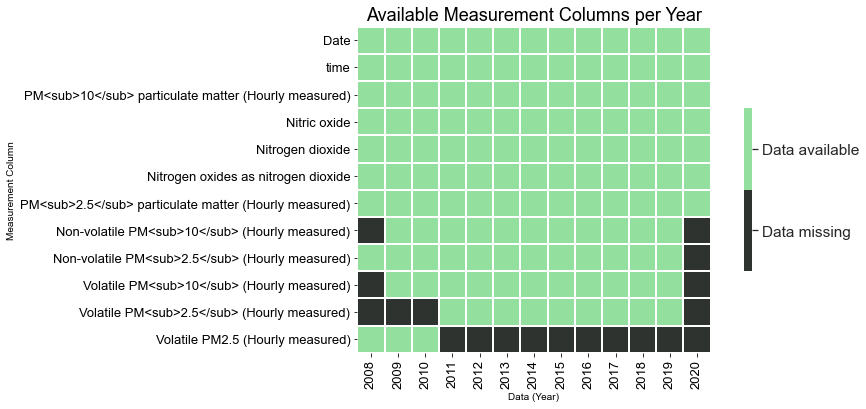

In [13]:
binary_colours = ["#2E332F", "#93DF9D"]
custom_cmap = LinearSegmentedColormap.from_list(
    "Custom", binary_colours, len(binary_colours)
)


fig, ax = plt.subplots(figsize=(12, 6))
sns.set_theme(font_scale=1.4)  # default text size
ax.tick_params(axis="both", labelsize=13)
sns.heatmap(
    m_plot_df, cmap=custom_cmap, square=True, linewidths=1, cbar_kws={"shrink": 0.5}
)
ax.set_title("Available Measurement Columns per Year", fontsize=18)
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0.25, 0.75])
colorbar.set_ticklabels(["Data missing", "Data available"])

In [14]:
status_summary

,Data (Year),PM<sub>10</sub> particulate matter (Hourly measured) status,Nitric oxide status,Nitrogen dioxide status,Nitrogen oxides as nitrogen dioxide status,PM<sub>2.5</sub> particulate matter (Hourly measured) status,Non-volatile PM<sub>10</sub> (Hourly measured) status,Non-volatile PM<sub>2.5</sub> (Hourly measured) status,Volatile PM<sub>10</sub> (Hourly measured) status,Volatile PM<sub>2.5</sub> (Hourly measured) status,Volatile PM2.5 (Hourly measured) status
0,2020,2 different values,2 different values,2 different values,2 different values,2 different values,NaN,NaN,NaN,NaN,NaN
1,2019,R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),NaN
2,2018,R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),NaN
3,2017,R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),NaN
4,2016,R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),NaN
5,2015,R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),NaN
6,2014,R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),NaN
7,2013,R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),NaN
8,2012,R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),NaN
9,2011,R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),R (+ NaNs),NaN


In [15]:
unit_summary

,Data (Year),PM<sub>10</sub> particulate matter (Hourly measured) unit,Nitric oxide unit,Nitrogen dioxide unit,Nitrogen oxides as nitrogen dioxide unit,PM<sub>2.5</sub> particulate matter (Hourly measured) unit,Non-volatile PM<sub>10</sub> (Hourly measured) unit,Non-volatile PM<sub>2.5</sub> (Hourly measured) unit,Volatile PM<sub>10</sub> (Hourly measured) unit,Volatile PM<sub>2.5</sub> (Hourly measured) unit,Volatile PM2.5 (Hourly measured) unit
0,2020,ugm-3 (FIDAS) (+ NaNs),ugm-3 (+ NaNs),ugm-3 (+ NaNs),ugm-3 (+ NaNs),ugm-3 (Ref.eq) (+ NaNs),NaN,NaN,NaN,NaN,NaN
1,2019,2 different values,ugm-3 (+ NaNs),ugm-3 (+ NaNs),ugm-3 (+ NaNs),2 different values,ugm-3 (TEOM FDMS) (+ NaNs),ugm-3 (TEOM FDMS) (+ NaNs),ugm-3 (TEOM FDMS) (+ NaNs),ugm-3 (TEOM FDMS) (+ NaNs),NaN
2,2018,ugm-3 (TEOM FDMS) (+ NaNs),ugm-3 (+ NaNs),ugm-3 (+ NaNs),ugm-3 (+ NaNs),ugm-3 (TEOM FDMS) (+ NaNs),ugm-3 (TEOM FDMS) (+ NaNs),ugm-3 (TEOM FDMS) (+ NaNs),ugm-3 (TEOM FDMS) (+ NaNs),ugm-3 (TEOM FDMS) (+ NaNs),NaN
3,2017,ugm-3 (TEOM FDMS) (+ NaNs),ugm-3 (+ NaNs),ugm-3 (+ NaNs),ugm-3 (+ NaNs),ugm-3 (TEOM FDMS) (+ NaNs),ugm-3 (TEOM FDMS) (+ NaNs),ugm-3 (TEOM FDMS) (+ NaNs),ugm-3 (TEOM FDMS) (+ NaNs),ugm-3 (TEOM FDMS) (+ NaNs),NaN
4,2016,ugm-3 (TEOM FDMS) (+ NaNs),ugm-3 (+ NaNs),ugm-3 (+ NaNs),ugm-3 (+ NaNs),ugm-3 (TEOM FDMS) (+ NaNs),ugm-3 (TEOM FDMS) (+ NaNs),ugm-3 (TEOM FDMS) (+ NaNs),ugm-3 (TEOM FDMS) (+ NaNs),ugm-3 (TEOM FDMS) (+ NaNs),NaN
5,2015,ugm-3 (TEOM FDMS) (+ NaNs),ugm-3 (+ NaNs),ugm-3 (+ NaNs),ugm-3 (+ NaNs),ugm-3 (TEOM FDMS) (+ NaNs),ugm-3 (TEOM FDMS) (+ NaNs),ugm-3 (TEOM FDMS) (+ NaNs),ugm-3 (TEOM FDMS) (+ NaNs),ugm-3 (TEOM FDMS) (+ NaNs),NaN
6,2014,ugm-3 (TEOM FDMS) (+ NaNs),ugm-3 (+ NaNs),ugm-3 (+ NaNs),ugm-3 (+ NaNs),ugm-3 (TEOM FDMS) (+ NaNs),ugm-3 (TEOM FDMS) (+ NaNs),ugm-3 (TEOM FDMS) (+ NaNs),ugm-3 (TEOM FDMS) (+ NaNs),ugm-3 (TEOM FDMS) (+ NaNs),NaN
7,2013,ugm-3 (TEOM FDMS) (+ NaNs),ugm-3 (+ NaNs),ugm-3 (+ NaNs),ugm-3 (+ NaNs),ugm-3 (TEOM FDMS) (+ NaNs),ugm-3 (TEOM FDMS) (+ NaNs),ugm-3 (TEOM FDMS) (+ NaNs),ugm-3 (TEOM FDMS) (+ NaNs),ugm-3 (TEOM FDMS) (+ NaNs),NaN
8,2012,ugm-3 (TEOM FDMS) (+ NaNs),ugm-3 (+ NaNs),ugm-3 (+ NaNs),ugm-3 (+ NaNs),ugm-3 (TEOM FDMS) (+ NaNs),ugm-3 (TEOM FDMS) (+ NaNs),ugm-3 (TEOM FDMS) (+ NaNs),ugm-3 (TEOM FDMS) (+ NaNs),ugm-3 (TEOM FDMS) (+ NaNs),NaN
9,2011,ugm-3 (TEOM FDMS) (+ NaNs),ugm-3 (+ NaNs),ugm-3 (+ NaNs),ugm-3 (+ NaNs),ugm-3 (TEOM FDMS) (+ NaNs),ugm-3 (TEOM FDMS) (+ NaNs),ugm-3 (TEOM FDMS) (+ NaNs),ugm-3 (TEOM FDMS) (+ NaNs),ugm-3 (TEOM FDMS) (+ NaNs),NaN


## NOTES
Now have to:
- ~~Fill each of the summary tables appropriately~~
- ~~Fill a data dictionary with the raw data from .csv (with converted metadata column names)~~
- Apply any necessary column title changes (update to something more sensible)
- Order with above uncertain... Merge separate DataFrames together to give a complete set
- Save the merged DataFrame

Where years have both volatile and non-volatile particulate matter readings: the sum of these two values corresponds to the value in the 'PM<sub>xx</sub>' column (see ['compare particulate matter readings'](#compare-particulate-matter-readings) section below). Happy to just drop these for now (as they're not included in all years). Use the cell below to extract those columns that are to be dropped (data not available for all years)

In [7]:
common_columns = pd.Series(inspect_columns.all())
drop_columns = common_columns.copy()
drop_columns = drop_columns[~drop_columns]
drop_columns = drop_columns.index.tolist()

volatile = (
    air_pollution.copy()
)  # define new DataFrame for section below before columns are dropped

air_pollution.drop(drop_columns, axis="columns", inplace=True)

### Compare particulate matter readings
Check to ensure that the volatile/non-volatile particulate matter readings sum to give the associated generic value for both 2.5 and 10 $\mu m$ sizes.  
Start by defining a new subset of the data looking only at the columns of interest (for a small portion of the data):

In [8]:
volatile = volatile[
    [
        "date",
        "Non-volatile PM<sub>2.5</sub> (Hourly measured)",
        "Volatile PM<sub>2.5</sub> (Hourly measured)",
        "pm_2_5",
        "Non-volatile PM<sub>10</sub> (Hourly measured)",
        "Volatile PM<sub>10</sub> (Hourly measured)",
        "pm_10",
    ]
]
# sample_size = 5
# volatile = volatile.sample(sample_size, random_state=5)

For this sample data, define two new columns that sum the values in the volatile and non-volatile column for each size. Then, compare the values in this column to those in the generic column for each row:

In [9]:
volatile["sum_2_5"] = (
    volatile["Non-volatile PM<sub>2.5</sub> (Hourly measured)"]
    + volatile["Volatile PM<sub>2.5</sub> (Hourly measured)"]
).round(1)
volatile["sum_10"] = (
    volatile["Non-volatile PM<sub>10</sub> (Hourly measured)"]
    + volatile["Volatile PM<sub>10</sub> (Hourly measured)"]
).round(1)
volatile.reset_index(drop=True, inplace=True)
volatile

,date,Non-volatile PM<sub>2.5</sub> (Hourly measured),Volatile PM<sub>2.5</sub> (Hourly measured),pm_2_5,Non-volatile PM<sub>10</sub> (Hourly measured),Volatile PM<sub>10</sub> (Hourly measured),pm_10,sum_2_5,sum_10
0,2008-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,29.0,NaN,NaN
1,2008-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,29.0,NaN,NaN
2,2008-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,19.0,NaN,NaN
3,2008-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,16.0,NaN,NaN
4,2008-01-01 05:00:00,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
107443,2020-04-03 20:00:00,NaN,NaN,5.660,NaN,NaN,9.3,NaN,NaN
107444,2020-04-03 21:00:00,NaN,NaN,8.396,NaN,NaN,12.1,NaN,NaN
107445,2020-04-03 22:00:00,NaN,NaN,12.925,NaN,NaN,16.9,NaN,NaN
107446,2020-04-03 23:00:00,NaN,NaN,13.208,NaN,NaN,17.7,NaN,NaN


Cell below prints df for those particulate matter values don't add up as we expect:

In [10]:
check_equal = volatile.copy()
equal_mask = (
    (check_equal["pm_2_5"] == check_equal["sum_2_5"])
    | (
        (check_equal["Non-volatile PM<sub>2.5</sub> (Hourly measured)"].isna())
        & (check_equal["Volatile PM<sub>2.5</sub> (Hourly measured)"].isna())
    )
) & (
    (check_equal["pm_10"] == check_equal["sum_10"])
    | (
        (check_equal["Non-volatile PM<sub>10</sub> (Hourly measured)"].isna())
        & (check_equal["Volatile PM<sub>10</sub> (Hourly measured)"].isna())
    )
)

conflicts = check_equal.copy()
conflicts = conflicts[~equal_mask]

In [11]:
conflicts

,date,Non-volatile PM<sub>2.5</sub> (Hourly measured),Volatile PM<sub>2.5</sub> (Hourly measured),pm_2_5,Non-volatile PM<sub>10</sub> (Hourly measured),Volatile PM<sub>10</sub> (Hourly measured),pm_10,sum_2_5,sum_10
95304,2018-11-15 01:00:00,11.2,6.8,14.5,16.3,3.3,19.6,18.0,19.6
95305,2018-11-15 02:00:00,15.8,2.6,14.9,17.3,4.4,21.7,18.4,21.7
95306,2018-11-15 03:00:00,13.5,7.9,17.9,17.2,4.8,22.0,21.4,22.0
95307,2018-11-15 04:00:00,15.6,3.0,15.1,15.0,4.4,19.4,18.6,19.4
95308,2018-11-15 05:00:00,9.3,7.2,13.0,13.4,3.8,17.2,16.5,17.2
...,...,...,...,...,...,...,...,...,...
97172,2019-01-31 21:00:00,NaN,NaN,NaN,16.5,1.9,13.1,NaN,18.4
97173,2019-01-31 22:00:00,NaN,NaN,NaN,19.0,2.1,15.8,NaN,21.1
97174,2019-01-31 23:00:00,NaN,NaN,NaN,14.5,4.4,13.6,NaN,18.9
97175,2019-02-01 00:00:00,NaN,NaN,NaN,10.5,5.3,10.5,NaN,15.8


In [12]:
percentage_conflicts = (len(conflicts) / len(volatile)) * 100
print(
    f"{percentage_conflicts} % of data shows difference between calculated and raw data values of general particulate matter measurements"
)

1.616595934777753 % of data shows difference between calculated and raw data values of general particulate matter measurements


One 'ToDo' is to expand the above check into a general check against the full final-state DataFrame...

## Save composite data file

In [13]:
if not interim_data_path.is_dir():
    interim_data_path.mkdir(parents=True)

save_location = interim_data_path / "oxford_ebbes_full.csv"
air_pollution.to_csv(save_location, index=False)
print(f"Full historic air pollution data saved to: {save_location}")

Full historic air pollution data saved to: /Users/Simon/Documents/Python_Projects/Productivity Boiz/air-pollution/data/interim/oxford_ebbes_full.csv
